**STEP - 1 : IMPORT THE REQUIRED LIBRARIES**

In [63]:
# A. Import Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

# B. Import Libraries Required For ARIMA Model
import statsmodels.api as sm

# C. Import Libraries Required For Developing ML Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
! pip install lightgbm
from lightgbm import LGBMRegressor

# D. Import Libraries Required For Hypertuning The ML Models
from sklearn.model_selection import GridSearchCV

# E. Import Libraries Required For Evaluating The ML Models
from sklearn.metrics import mean_squared_error

**STEP - 2 : LOAD THE DATA**

In [64]:
file_path = r"C:\Users\titik\OneDrive\Desktop\Data Science\Analytics Capstone Project\amz_uk_processed_data.csv"
data = pd.read_csv(file_path)
# Take 35% Of Data
data_sample = data.sample(frac=0.35, random_state=42)
data_sample.head(1)

,asin,title,imgUrl,productURL,stars,reviews,price,isBestSeller,boughtInLastMonth,categoryName
673381,B00XLHSZ74,AQUALONA® Premium Thermoplastic Toilet Seat - ...,https://m.media-amazon.com/images/I/21PBcPK8A0...,https://www.amazon.co.uk/dp/B00XLHSZ74,4.5,393,26.99,False,1000,Kitchen & Bath Fixtures


In [65]:
data_sample.shape # Rows and Columns of dataset respectively

(777960, 10)

**STEP - 3 : DATA PREPARATION**

**3.1. FEATURE ENGINEERING**

*(I) DROP UNREQUIRED FEATURES AND RENAME THE REQUIRED ONES*

In [66]:
# (A) Drop The Unrequired Columns From The Dataframe
data_sample = data_sample.drop(['asin','imgUrl', 'productURL', 'boughtInLastMonth'], axis = 1)

In [67]:
# (B) Rename The Columns Names
data_sample = data_sample.rename(columns = {'stars' : 'Stars', 'reviews' : 'Reviews', 'price' : 'Price', 
                              'isBestSeller' : 'IsBestSeller', 'categoryName' : 'CategoryName'})

*(II) ADD FEATURES REQUIRED FOR DEVELOPING ML MODELS*

In [68]:
# (A) Extract Brand Name And Product Name Using str.split()
data_sample['Brand Name'] = data_sample['title'].str.split('|').str[0].str.split().str[0]
data_sample['Product Name'] = data_sample['title'].str.split().str[1:].str.join(' ')

In [69]:
# (B) Compute Brand Strength
# 0 = unfamous brand, 1 = famous brand
data_sample['Brand Strength'] = data_sample['IsBestSeller'].astype(int)

In [70]:
# (C) Compute Popularity Score
# Approximate popularity score for each product (multiply stars with reviews)
data_sample['Popularity Score'] = data_sample['Stars']*data_sample['Reviews']

In [71]:
# (D) Compute Price Elasticity
# Lower the price elasticity, price change won't lose sales (i.e., product is more popular and can handle price change)
data_sample['Price Elasticity'] = data_sample['Price']/(data_sample['Popularity Score'])

In [72]:
# (E) Compute Inventory Turnover Rate
# Higher ITR : Fast Moving Products while Lower ITR : Potential Overstock
data_sample['Inventory Turnover Rate'] = data_sample['Reviews']/data_sample['Price']

In [73]:
# (F) Compute Category Level Market Share
# Higher the market share, higher the dominance in that particular category
data_sample['Market Share'] = data_sample['Reviews'] / data_sample.groupby('CategoryName')['Reviews'].transform('sum')

In [74]:
# (G) Compute Revenue
# Total amount of money generated from sales : higher the revenue, higher the profit (sales performance)
data_sample['Revenue'] = data_sample['Price'] * data_sample['Popularity Score']

In [75]:
# (H) Compute Profit
# Remains after all expenses deducted from revenue
data_sample['Cost Percentage'] = 0.7 * data_sample['Price']
data_sample['Profit'] = (data_sample['Price'] * (1 - data_sample['Cost Percentage'])) * data_sample['Popularity Score']

Important Features : 

1. Price Elasticity, Competitor Price Comparison, Sale Growth : gives in depth details of product sales
2. Inventory Turnover Rate : gives in depth details of stock inventory

*(III) ADD FEATURES REQUIRED FOR DATETIMESTAMP AND CHECKING BERRISH/BULLISH SIGNALS*

In [76]:
#Given the information, data has been scrapped in October 2023

np.random.seed(42) 

# (A) Compute the Year And Month {random} package
data_sample['Year'] = np.random.choice([2023], size=len(data_sample))
data_sample['Month'] = np.random.randint(10, 13, size=len(data_sample))

In [77]:
# (B) Moving Average For Price
# Short Term MA
data_sample['MA_50_Price'] = data_sample['Price'].rolling(window = 50, min_periods = 1).mean()
# Long Term MA
data_sample['MA_200_Price'] = data_sample['Price'].rolling(window = 200, min_periods = 1).mean()

In [78]:
# (D) MA Signals Bullish / Berrish
# If Short Term MA > Long Term MA meaning prices rising in Short Term as compared to Long Term thus Bullish signal else Berrish
data_sample['Bullish/Berrish_Price'] = np.where(data_sample['MA_50_Price'] > data_sample['MA_200_Price'], 'Bullish', 'Berrish')

**3.2. CLEAN THE DATA**

*(I) DROP NaN and inf Values FROM THE DATASET*

In [79]:
data_sample = data_sample.dropna()

*(II) DROP UNNECESARY FEATURES SINCE FEATURE ENGINEERING IS COMPLETE AND NOT MORE NEEDED*

In [80]:
data_sample = data_sample.drop(['title', 'Stars', 'Reviews', 'IsBestSeller', 'Brand Strength'], axis=1)

**STEP - 4 : PERFORM EXPLORATORY DATA ANALYSIS**

**4.1. UNDERSTAND THE DATA**

In [81]:
data_sample.head(1) # Get the first row of dataset

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Cost Percentage,Profit,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,18.893,-854065.365795,2023,12,26.99,26.99,Berrish


In [82]:
data_sample.tail(1) # Get the last row of dataset

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Cost Percentage,Profit,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price
1346918,26.77,Sports & Outdoors,Tennis,"Racket, Ultralight Carbon Tennis Racket, PU Wr...",0.0,inf,0.0,0.0,0.0,18.739,-0.0,2023,11,318.2108,136.3453,Bullish


In [83]:
data_sample.shape # Rows and Columns of dataset respectively

(777881, 16)

In [84]:
data_sample.dtypes # Datatypes of the features within dataset

Price                      float64
CategoryName                object
Brand Name                  object
Product Name                object
Popularity Score           float64
Price Elasticity           float64
Inventory Turnover Rate    float64
Market Share               float64
Revenue                    float64
Cost Percentage            float64
Profit                     float64
Year                         int32
Month                        int32
MA_50_Price                float64
MA_200_Price               float64
Bullish/Berrish_Price       object
dtype: object

In [85]:
data_sample.isna().sum() # If any null values within dataset

Price                      0
CategoryName               0
Brand Name                 0
Product Name               0
Popularity Score           0
Price Elasticity           0
Inventory Turnover Rate    0
Market Share               0
Revenue                    0
Cost Percentage            0
Profit                     0
Year                       0
Month                      0
MA_50_Price                0
MA_200_Price               0
Bullish/Berrish_Price      0
dtype: int64

**4.2. DESIGN VISUALIZATIONS**

*(I) MONTHLY PRICE VISUALIZATION*

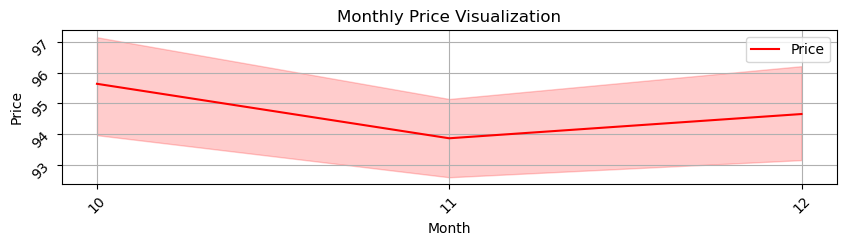

In [86]:
plt.figure(figsize=(10, 2))
sns.lineplot(x='Month', y='Price', data=data_sample, label='Price', color = 'red')
plt.title("Monthly Price Visualization")
plt.xlabel("Month")
plt.ylabel("Price")
plt.xticks(ticks = [10, 11, 12], rotation=45)
plt.yticks(rotation=45)
plt.grid()
plt.show()

*(II) VISUALIZE BERRISH/BULLISH SIGNALS FOR PRICE*

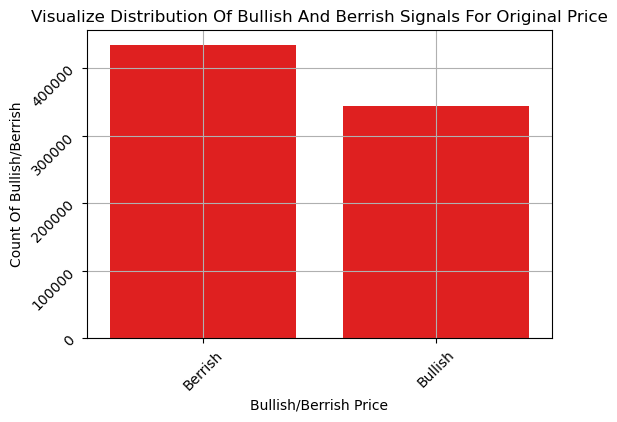

In [87]:
plt.figure(figsize = (6,4))
sns.countplot(data = data_sample, x = 'Bullish/Berrish_Price', color = 'red')
plt.xlabel('Bullish/Berrish Price')
plt.ylabel('Count Of Bullish/Berrish')
plt.title('Visualize Distribution Of Bullish And Berrish Signals For Original Price')
plt.grid()
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

*(III) POSSIBLE CAUSES FOR THE POOR SALES*  

1. Holidays / Promotions
2. A Mix Of Seasonal Shopping Patterns
3. Better quality products over offline shops or other ecommerce platforms
4. Shipping cost
5. Unoptimal prices of products
6. Poor quality of products
7. Unavailability of particular product in stock

**STEP - 5 : DEVELOPE TIME SERIES (ARIMA : Auto Regressive Integrated Moving Average) MODEL**

**(A) ADD DATE FEATURE SINCE IT WAS NOT PRESENT INITIALLY**

In [88]:
# Calculate Days And Add Date With Days, Months And Years Since Date Feature Is Not Present In Dataset
# Map Days To Month
days_in_month = {10: 31, 11: 30, 12: 31}
# Assign Day Based On Month Value
data_sample['Day'] = data_sample['Month'].map(days_in_month)
# Combine Year, Month And Day To Date Feature
data_sample['Date'] = pd.to_datetime(data_sample[['Year', 'Month', 'Day']])
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Cost Percentage,Profit,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price,Day,Date
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,18.893,-854065.365795,2023,12,26.99,26.99,Berrish,31,2023-12-31


**(B) DEVELOPE AND FIT THE ARIMA MODEL**

ARIMA Model Order :
1. p : set this term for AR (Auto Regressive) to 1, that defines how many past values model uses to predict current value
2. d : set this term for I (Integrated) to 1, that defines number of times data has been differenced to make it stationary 
3. q : set this term for MA (Moving Average) to 1, that defines how many forecast error model uses to predict current value

In [89]:
# Develope ARIMA Model 
ARIMA_model = sm.tsa.ARIMA(data_sample[['Price']], order = (1, 1, 1))
# Fit ARIMA Model
model_fit = ARIMA_model.fit()

C:\Users\titik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\titik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\titik\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


**(C) MAKE ARIMA PREDICTIONS**

In [90]:
# Forecasted Prices (i.e., ARIMA Predictions)
Forecasted_Prices = model_fit.predict(start=1, typ='levels')
data_sample['ARIMA_ForecastedPrices'] = Forecasted_Prices
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Cost Percentage,Profit,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price,Day,Date,ARIMA_ForecastedPrices
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,18.893,-854065.365795,2023,12,26.99,26.99,Berrish,31,2023-12-31,NaN


In [91]:
# Replace NaN With Mean
mean_forecasted_price = data_sample['ARIMA_ForecastedPrices'].mean()
data_sample['ARIMA_ForecastedPrices'].fillna(mean_forecasted_price, inplace = True)
data_sample.head(1)

C:\Users\titik\AppData\Local\Temp\ipykernel_17196\597489140.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_sample['ARIMA_ForecastedPrices'].fillna(mean_forecasted_price, inplace = True)


,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Cost Percentage,Profit,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price,Day,Date,ARIMA_ForecastedPrices
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,18.893,-854065.365795,2023,12,26.99,26.99,Berrish,31,2023-12-31,94.644415


***NOTE***

Here we have obtained the forecasted prices using a Time Series model, i.e., ARIMA model whose output (Forecasted Prices) will be used as input for the Machine Learning models in order to predict optimal prices

**STEP - 6 : PRE-REQUISITES FOR DEVELOPING ML MODELS**

**6.1. SELECT REQUIRED FEATURES** 

In [92]:
mlModel_features = data_sample[['ARIMA_ForecastedPrices','Popularity Score', 'Price Elasticity', 
                                'Inventory Turnover Rate', 'Market Share', 'Revenue', 'Profit']]
mlModel_features.head(1)

,ARIMA_ForecastedPrices,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Profit
673381,94.644415,1768.5,0.015262,14.560948,0.0004,47731.815,-854065.365795


1. We have used target variable Price for Time Series model and obtained Forecasted Prices with AR, I and MA set to 1 which means throughout the calculations one past value; one differencing and one forecasted error were used for ARIMA modeling
2. Since we have obtained new dynamic Forecasted Prices after using Time Series model, this is our new target variable throughout developing and evaluating ML Models

**6.2. GET THE TRAIN AND TEST DATASET**

In [93]:
# Where, test_size = 20% & train_size = 80%
X = mlModel_features
Y = data_sample[['Price']]
X_train, X_test, Y_train, Y_test =train_test_split(X,Y,test_size= 0.20, random_state=16)

**STEP - 7 : DEVELOPE RANDOM FOREST MODEL AND EVALUATE** 

**7.1. DEVELOPE RANDOM FOREST REGRESSOR MODEL AND FIT THE DATA**

In [94]:
# Replace If Any Infinity Values With NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_Train (Imputation)
X_train.fillna(X_train.mean(), inplace=True) 

# Initialize The Model
rf_regressor = RandomForestRegressor(random_state = 42)

# Fit The Model
rf_regressor.fit(X_train, Y_train)

C:\Users\titik\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

**7.2. TEST THE MODEL**

In [95]:
# Replace If Any Infinity Values With NaN
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_test (Imputation)
X_test.fillna(X_test.mean(), inplace=True) 

# Test The Model
RF_Pred = rf_regressor.predict(X_test)

**7.3. EVALUATE THE MODEL** 

In [96]:
# Replace If Any Infinity Values With NaN
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of Y_test (Imputation)
Y_test.fillna(Y_test.mean(), inplace=True) 

# Compute MSE 
rf_mse = mean_squared_error(Y_test, RF_Pred)

# Compute RMSE
rf_rmse = np.sqrt(rf_mse)

# Print RMSE
print('RF RMSE : ', rf_rmse)

RF RMSE :  487.9187064846689


**STEP - 8 : HYPERTUNE THE MODEL AND EVALUATE IT**

**8.1. DEFINE THE PARAMETER GRID FOR TUNING THE RF REGRESSOR MODEL**

In [97]:
param_grid = {
    'n_estimators': [5],               
    'max_features': ['sqrt'],
    'max_depth': [5],
    'min_samples_split': [5],
    'min_samples_leaf': [5],
    'bootstrap': [True]
}

**8.2. PERFORM GRID SEARCH**

In [98]:
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    cv=3,                   
    n_jobs=2,               
    verbose=2
)

**8.3. FIT THE MODEL IN GRID SEARCH**

In [99]:
# Replace If Any Infinity Values With NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_Train (Imputation)
X_train.fillna(X_train.mean(), inplace=True) 

# Fit The Model In Grid Search
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\titik\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=2,
             param_grid={'bootstrap': [True], 'max_depth': [5],
                         'max_features': ['sqrt'], 'min_samples_leaf': [5],
                         'min_samples_split': [5], 'n_estimators': [5]},
             verbose=2)

**8.4. TEST THE HYPERTUNED MODEL**

In [100]:
# Replace If Any Infinity Values With NaN
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_test (Imputation)
X_test.fillna(X_test.mean(), inplace=True) 

# Test The Model
Hypertuned_RF_Pred = grid_search.predict(X_test)

**8.5. EVALUATE THE HYPERTUNED MODEL**

In [101]:
# Replace If Any Infinity Values With NaN
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of Y_test (Imputation)
Y_test.fillna(Y_test.mean(), inplace=True) 

# Compute MSE 
rf_Hypertuned_mse = mean_squared_error(Y_test, Hypertuned_RF_Pred)

# Compute RMSE
rf_Hypertuned_rmse = np.sqrt(rf_Hypertuned_mse)

# Print RMSE
print('RF Hypertuned RMSE : ', rf_Hypertuned_rmse)

RF Hypertuned RMSE :  431.79860042727245


Findings :

Upon comparing RMSE of Random Forest Regressor as well as hypertuned Random Forest regressor we can see hypertuned random forest regressor is performing good as compared to random forest regressor which can be depicted by the decrease in Root Mean Squared Error (RMSE)

Next Steps :

Though the perfomance of hypertuned random forest regressor model is good, there is still room for improvement in RMSE by implementing more robust models like LGBM Regressor

**STEP - 9 : DEVELOPE LGBM MODEL AND EVALUATE IT**

**9.1. DEVELOPE LGBM REGRESSOR MODEL AND FIT THE DATA**

In [102]:
# Replace If Any Infinity Values With NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_Train (Imputation)
X_train.fillna(X_train.mean(), inplace=True) 

# Initialize The Model
lgbm_regressor = LGBMRegressor(
   random_state=42, n_estimators=2000, learning_rate=1, max_depth=5     
)

# Fit The Model
lgbm_regressor.fit(X_train, Y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 622304, number of used features: 7
[LightGBM] [Info] Start training from score 94.528054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

LGBMRegressor(learning_rate=1, max_depth=5, n_estimators=2000, random_state=42)

**9.2. TEST THE MODEL**

In [103]:
# Replace If Any Infinity Values With NaN
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_test (Imputation)
X_test.fillna(X_test.mean(), inplace=True) 

# Test The Model
LGBM_Pred = lgbm_regressor.predict(X_test)

**9.3. EVALUATE THE MODEL**

In [104]:
# Replace If Any Infinity Values With NaN
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of Y_test (Imputation)
Y_test.fillna(Y_test.mean(), inplace=True) 

# Compute MSE 
lgbm_mse = mean_squared_error(Y_test, LGBM_Pred)

# Compute RMSE
lgbm_rmse = np.sqrt(lgbm_mse)

# Print RMSE
print('LGBM RMSE : ', lgbm_rmse)

LGBM RMSE :  430.0268812972037


**STEP - 10 : HYPERTUNE THE MODEL AND EVALUATE IT**

**10.1. DEFINE THE PARAMETER GRID FOR TUNING LGBM REGRESSOR MODEL**

In [105]:
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [1], 
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
}

**10.2. PERFORM GRID SEARCH**

In [106]:
grid_search = GridSearchCV(estimator=lgbm_regressor, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', 
                           verbose=2, n_jobs=-1)

**10.3. FIT THE DATA IN GRID SEARCH MODEL**

In [107]:
# Replace If Any Infinity Values With NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_Train (Imputation)
X_train.fillna(X_train.mean(), inplace=True) 

grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 622304, number of used features: 7
[LightGBM] [Info] Start training from score 94.528054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

GridSearchCV(cv=5,
             estimator=LGBMRegressor(learning_rate=1, max_depth=5,
                                     n_estimators=2000, random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [1], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [500, 1000, 1500]},
             scoring='neg_root_mean_squared_error', verbose=2)

**10.4. TEST THE MODEL**

In [108]:
# Replace If Any Infinity Values With NaN
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of X_test (Imputation)
X_test.fillna(X_test.mean(), inplace=True) 

# Test The Model
Hypertuned_LGBM_Pred = grid_search.predict(X_test)

**10.5. EVALUATE THE MODEL**

In [109]:
# Replace If Any Infinity Values With NaN
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN Values With Mean Of Y_test (Imputation)
Y_test.fillna(Y_test.mean(), inplace=True) 

# Compute MSE 
lgbm_Hypertuned_mse = mean_squared_error(Y_test, Hypertuned_LGBM_Pred)

# Compute RMSE
lgbm_Hypertuned_rmse = np.sqrt(lgbm_Hypertuned_mse)

# Print RMSE
print('LGBM Hypertuned RMSE : ', lgbm_Hypertuned_rmse)

LGBM Hypertuned RMSE :  429.94668419182085


**STEP - 11 : COMPARE THE RMSE's OF ALL FOUR MODELS**

In [110]:
print(f'Random Forest Regressor RMSE : {rf_rmse:.2f}')
print(f'Hypertuned Random Forest Regressor RMSE : {rf_Hypertuned_rmse:.2f}')
print(f'Light Gradient Boosting Machine Regressor RMSE : {lgbm_rmse:.2f}')
print(f'Hypertuned Light Gradient Boosting Machine Regressor RMSE : {lgbm_Hypertuned_rmse:.2f}')

Random Forest Regressor RMSE : 487.92
Hypertuned Random Forest Regressor RMSE : 431.80
Light Gradient Boosting Machine Regressor RMSE : 430.03
Hypertuned Light Gradient Boosting Machine Regressor RMSE : 429.95


1. Upon comparing RMSE's of all the four models, we can see Hypertuned Light Gradient Boosting Machine Regressor model is performing good with the least Root Mean Squared Error of 429.95
2. Thus, we will add the predictions of this model to original dataset since this model has performed best out of all

**STEP - 12 : ADD PREDICTIONS TO THE DATASET**

In [111]:
# Truncate data_sample to the first 155577 rows to match Hypertuned_LGBM_Pred
data_sample = data_sample.iloc[:len(Hypertuned_LGBM_Pred)]
data_sample['Hypertuned LGBM Predictions'] = Hypertuned_LGBM_Pred

In [112]:
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Revenue,Cost Percentage,Profit,Year,Month,MA_50_Price,MA_200_Price,Bullish/Berrish_Price,Day,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,47731.815,18.893,-854065.365795,2023,12,26.99,26.99,Berrish,31,2023-12-31,94.644415,8.414505


1. Until now, I have done feature engineering; analyzing visualizations and hybrid modelling
2. When ARIMA model's predictions inputted with four other ML model : RF, Hypertuned RF, LGBM and Hypertuned LGBM Regressor the best hybrid model was Hypertuned LGBM with less RMSE of 429.95; whose predictions were added back in original dataset
3. The primary goal of this project is to obtain Optimal Prices in order to increase profitability for the available historic dataset which can be evaluated as Bullish > Berrish
4. With the key features and the other two obtained primary features, I intend to work on the computation of Optimal Prices and evaluate the same

**STEP - 13 : REMOVE THE UNREQUIRED COLUMNS**

In [113]:
data_sample = data_sample.drop(['Year', 'MA_50_Price',	'MA_200_Price',	'Bullish/Berrish_Price', 'Profit', 'Revenue',
                                'Day', 'Cost Percentage'], axis = 1)
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Month,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,12,2023-12-31,94.644415,8.414505


**STEP - 14 : OPTIMAL PRICES UPON COMPARING ARIMA FORECASTED PRICES AND HYPERTUNED LGBM PREDICTIONS**

In [114]:
# Max Of ARIMA Forecasted Prices And Hypertuned LGBM Predictions
data_sample['Optimal Price'] = data_sample[['Hypertuned LGBM Predictions', 'ARIMA_ForecastedPrices']].max(axis=1)
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Month,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions,Optimal Price
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,12,2023-12-31,94.644415,8.414505,94.644415


**STEP - 15 : BOOST OPTIMAL PRICE BY USING POPULARTIY SCORE, INVENTORY TURNOVER RATE AND MARKET SHARE FEATURES**

In [115]:
# Since Higher Popularity Score, Inventory Turnover Rate And Higher Market Share Indicate Increase In Profitability 
# Supporting Higher Optimal Price

# If Popularity Score, Inventory Turnover Rate And Market Share Greater Than It's Median, Then Increase Optimal Price By 10%
high_popularity = data_sample['Popularity Score'] > data_sample['Popularity Score'].median()
high_market_share = data_sample['Market Share'] > data_sample['Market Share'].median()

data_sample.loc[high_popularity & high_market_share, 'Optimal Price'] *= 1.10  # Increase Optimal Price By 10%
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Month,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions,Optimal Price
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,12,2023-12-31,94.644415,8.414505,104.108856


In [116]:
high_inventoryTurnover_rate = data_sample['Inventory Turnover Rate'] > data_sample['Inventory Turnover Rate'].median()

data_sample.loc[high_inventoryTurnover_rate, 'Optimal Price'] *= 1.10  # Increase Optimal Price By 10%
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Month,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions,Optimal Price
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,12,2023-12-31,94.644415,8.414505,114.519742


**STEP - 16 : BOOST OPTIMAL PRICE BY USING PRICE ELASTICITY FEATURE**

In [117]:
# Since Lower Price Elasticity Won't Affect Sales If Price Increase, Thus Supporting Higher Optimal Price

# If Price Elasticity Less Than It's Median, Then Increase Optimal Price By 10%
low_priceElasticity = data_sample['Price Elasticity'] < data_sample['Price Elasticity'].median()

data_sample.loc[low_priceElasticity, 'Optimal Price'] *= 1.10  # Increase Optimal Price By 10%
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Month,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions,Optimal Price
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,12,2023-12-31,94.644415,8.414505,125.971716


**STEP - 17 : ADD BERRISH/BULLISH SIGNALS FOR THE NEWLY OBTAINED OPTIMAL PRICE**

In [118]:
data_sample['Bullish/Berrish_Optimal Price'] = data_sample.apply(
    lambda row: 'Bullish' if row['Optimal Price'] > row['Price'] else 'Bearish', axis=1
)
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Month,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions,Optimal Price,Bullish/Berrish_Optimal Price
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,12,2023-12-31,94.644415,8.414505,125.971716,Bullish


**STEP - 18 : FINAL CLEANUP OF DATASET AND PRINT UPDATED DATASET**

In [119]:
# Drop Infinity Values If Any
data_sample.replace([np.inf, -np.inf], np.nan, inplace=True)
data_sample.dropna(inplace=True)

# Print Final Updated Dataset
data_sample.head(1)

,Price,CategoryName,Brand Name,Product Name,Popularity Score,Price Elasticity,Inventory Turnover Rate,Market Share,Month,Date,ARIMA_ForecastedPrices,Hypertuned LGBM Predictions,Optimal Price,Bullish/Berrish_Optimal Price
673381,26.99,Kitchen & Bath Fixtures,AQUALONA®,Premium Thermoplastic Toilet Seat - Soft Close...,1768.5,0.015262,14.560948,0.0004,12,2023-12-31,94.644415,8.414505,125.971716,Bullish


**STEP - 19 : DESIGN THE VISUALIZATIONS IN ORDER TO SEE THE IMPROVEMENT IF ANY**

In [120]:
data_sample.shape

(73543, 14)

*(I) MONTHLY OPTIMAL PRICE IMPROVEMENT*

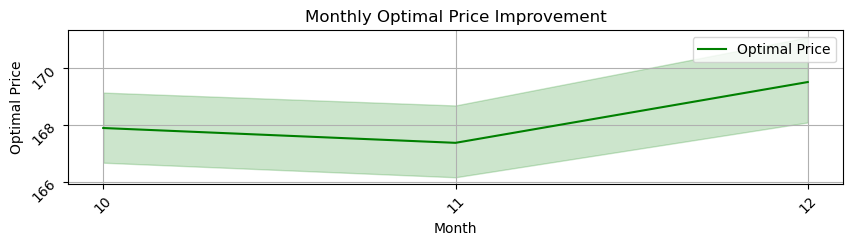

In [121]:
plt.figure(figsize=(10, 2))
sns.lineplot(x='Month', y='Optimal Price', data=data_sample, label='Optimal Price', color = 'green')
plt.title("Monthly Optimal Price Improvement")
plt.xlabel("Month")
plt.ylabel("Optimal Price")
plt.xticks(ticks = [10, 11, 12], rotation=45)
plt.yticks(rotation=45)
plt.grid()
plt.show()

*(II) VISUALIZE BERRISH/BULLISH SIGNALS FOR OPTIMAL PRICE*

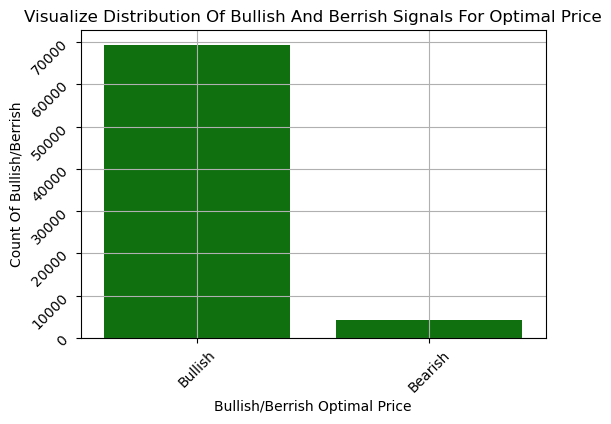

In [122]:
plt.figure(figsize = (6,4))
sns.countplot(data = data_sample, x = 'Bullish/Berrish_Optimal Price', color = 'green')
plt.xlabel('Bullish/Berrish Optimal Price')
plt.ylabel('Count Of Bullish/Berrish')
plt.title('Visualize Distribution Of Bullish And Berrish Signals For Optimal Price')
plt.grid()
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

**STEP - 20 : EVALUATE THE SALES PERFORMANCE UPON COMPARING THE AGGREGATED KEY METRICS**

*(I) COMPUTE REVENUE FOR PRICE AND OPTIMAL PRICE*

In [123]:
data_sample['Revenue_Price'] = data_sample['Price'] * data_sample['Popularity Score']

In [124]:
data_sample['Revenue_OptimalPrice'] = data_sample['Optimal Price'] * data_sample['Popularity Score']

*(II) COMPUTE PROFIT FOR PRICE AND OPTIMAL PRICE*

In [125]:
data_sample['Profit_Price'] = data_sample['Revenue_Price'] * (1 - data_sample['Price Elasticity'])

In [126]:
data_sample['Profit_OptimalPrice'] = data_sample['Revenue_OptimalPrice'] * (1 - data_sample['Price Elasticity'])

*(III) COMPUTE OPTIMIZED INVENTORY TURNOVER RATE*

In [127]:
data_sample['ITR_OptimalPrice'] = data_sample['Inventory Turnover Rate'] * (
    data_sample['Optimal Price'] / data_sample['Price']
)

*(IV) COMPUTE OPTIMIZED MARKET SHARE*

In [128]:
data_sample['MarketShare_OptimalPrice'] = data_sample['Market Share'] * (
    data_sample['Optimal Price'] / data_sample['Price']
)

*(V) COMPUTE OPTIMIZED POPULARITY GROWTH*

In [129]:
data_sample['PopularityScore_OptimalPrice'] = data_sample['Popularity Score'] * (
    data_sample['Optimal Price'] / data_sample['Price']
)

*(VI) COMPUTE OPTIMIZED PRICE ELASTICITY*

In [130]:
data_sample['PriceElasticity_OptimalPrice'] = data_sample['Price Elasticity'] * (
    data_sample['Optimal Price'] / data_sample['Price']
)

*(VII) COMPUTE AGGREGATED METRICS FOR PRICE*

In [131]:
Aggregated_PriceMetrics = {
    "Metric": ["Profit", "Revenue", "Inventory Turnover Rate", "Market Share", "Popularity Score", "Price Elasticity"],
    "Price": [
        data_sample['Profit_Price'].sum(),
        data_sample['Revenue_Price'].sum(),
        data_sample['Inventory Turnover Rate'].mean(),
        data_sample['Market Share'].mean(),
        data_sample['Popularity Score'].mean(),
        data_sample['Price Elasticity'].mean()
    ]
}

*(VIII) COMPUTE AGGREGATED METRICS FOR OPTIMAL PRICE*

In [132]:
Aggregated_OptimalPriceMetrics = {
    "Metric": ["Profit", "Revenue", "Inventory Turnover Rate", "Market Share", "Popularity Score", "Price Elasticity"],
    "Optimal Price": [
        data_sample['Profit_OptimalPrice'].sum(),
        data_sample['Revenue_OptimalPrice'].sum(),
        data_sample['ITR_OptimalPrice'].mean(),
        data_sample['MarketShare_OptimalPrice'].mean(),
        data_sample['PopularityScore_OptimalPrice'].mean(),
        data_sample['PriceElasticity_OptimalPrice'].mean()
    ]
}

*(IX) DESIGN COMPARISON TABLE FOR AGGREGATED METRICS*

In [135]:
Comparison_Table = pd.DataFrame(Aggregated_PriceMetrics).merge(
    pd.DataFrame(Aggregated_OptimalPriceMetrics), on="Metric"
)

Comparison_Table["Price"] = Comparison_Table["Price"].apply(lambda x: f"{x:.2f}")
Comparison_Table["Optimal Price"] = Comparison_Table["Optimal Price"].apply(lambda x: f"{x:.2f}")

*(X) DISPLAY THE FINAL COMPARISON TABLE*

In [136]:
print("\n Aggregated Metrics Comparison (Price vs Optimal Price) : ", '\n')
print(Comparison_Table.to_string(index=False))


 Aggregated Metrics Comparison (Price vs Optimal Price) :  

                 Metric         Price  Optimal Price
                 Profit 7918750859.21 42991436385.53
                Revenue 9319112887.44 43568037639.78
Inventory Turnover Rate         63.12        1806.84
           Market Share          0.00           0.01
       Popularity Score       3565.28       46982.67
       Price Elasticity          2.33           6.55


**STEP - 21 : RESULT OF THE EVALUATION**

The Aggregated Results Evaluation As :

1. Profit increase from 7.92 Billion to 42.99 Billion depicts the potential profitabitlity increase
2. Revenue Increase from 9.32 Billion to 43.57 Billion shows the increase in revenue
3. ITR increase from 63.12 to 1806.84 depicts the maximum sales of products
4. Market Share increase from 0.00 to 0.01 indicates the satisfaction of consumer behaviour as well as gain of attention in the competitive market
5. Popularity Score increase from 3565.28 to 46982.67 shows the satisfaction in consumer behaviour
6. Price Elasticity increase from 2.33 to 6.55 depicts the change of customer's buying habits based on the price adjustments

**THE FINAL CONCLUSION**

Starting with the historic dataset with the story of loss in sales throughout the year for given dataset upon performing analysis, to obtaining the optimal prices by using the output of hybrid models as well as key features; this project has helped to improvise the overall Revenue, Profit, ITR, Popularity Score, Market Share and Price Elasticity thus improving the performance of sales as well as consumer satisfaction

**POSSIBLE FUTURE WORK**

Following is the potential scope of future work for this project with detailed explaination :

Goal : To accomplish same project goals in a broader view

Step By Step Explaination : 

1. To replace real time data using API or building scrapper function for the same (Amazon has blocked the access) with the historical dataset
2. Perform feature engineering if required for aligning the overall dataset features with current dataset features in order to obtain the same project goals in a broader view
3. Faced the 'Pickling Error' that is memory leakage while implementing hybrid model, these models performance is restricted to 40% of data
4. To find and implement solutions for this (may be Deep Learning models or more robust models), since dealing with real time data in the hybrid model would cause more memory leakage